1. Take `building.jpg`

**a.** Use a simple filter like sobel to detect edge pixels. You can use opencv  (5pts)

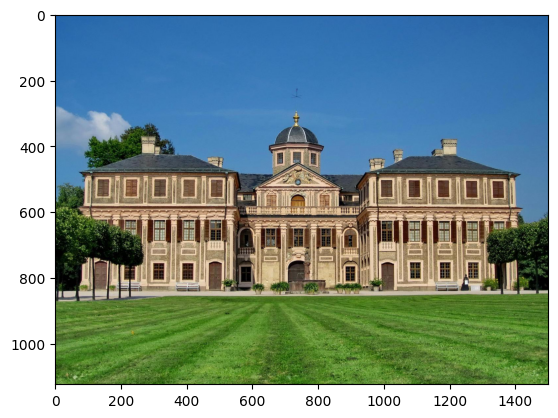

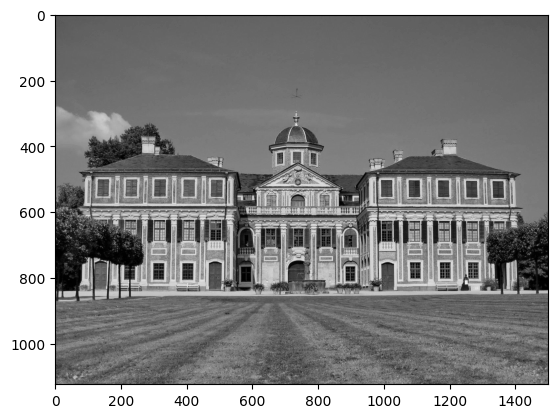

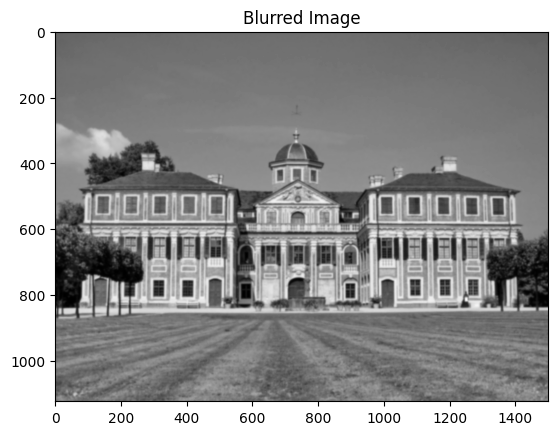

In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.signal import convolve2d
from gaussianfilter import gaussian_filter

# create the gaussian filter kernel
gaus_conv_kernel = gaussian_filter(sigma=2)

image = cv2.imread('building.jpg')
plt.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))
plt.show()
plt.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2GRAY), cmap='gray')
plt.show()
gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)

# apply the gaussian filter using 2d convolution
image_blurred = convolve2d(gray, gaus_conv_kernel, mode='same', boundary='wrap')
plt.imshow(image_blurred, cmap='gray')
plt.title('Blurred Image')
plt.show()

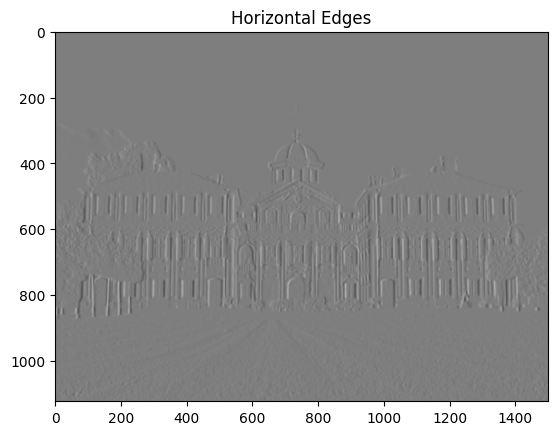

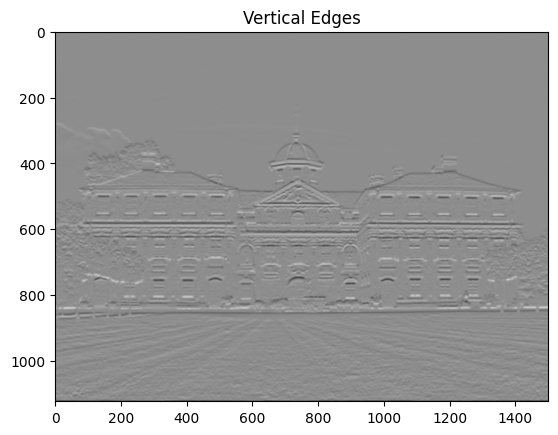

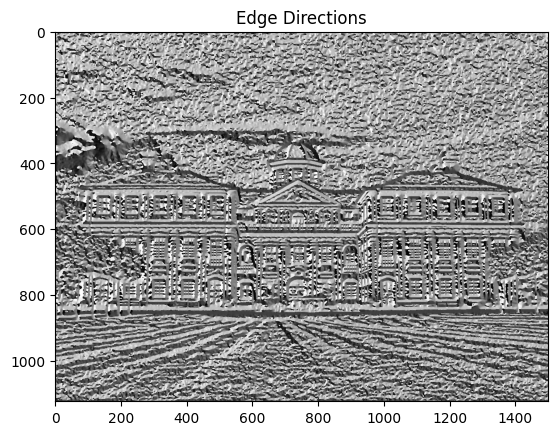

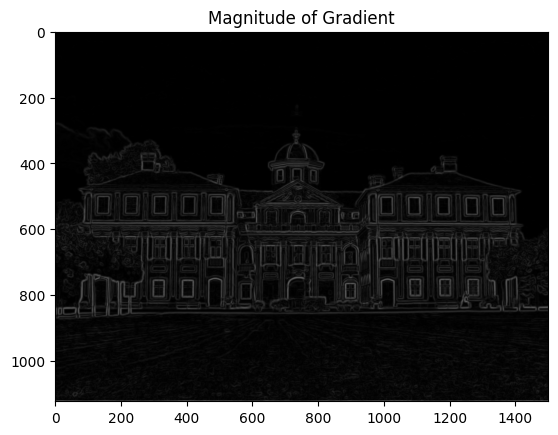

In [4]:
from scipy.signal import convolve2d
import numpy as np

# sobel filter:
filter = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])

def sobel(image,filter,show_output=False):
    x_derivative = convolve2d(image, filter, mode='same')
    y_derivative = convolve2d(image, np.flip(filter.T,axis=0), mode='same')

    magnitude_gradient = np.sqrt(np.square(x_derivative) + np.square(y_derivative))
    #normalise the output:
    magnitude_gradient = magnitude_gradient*(255.0 / magnitude_gradient.max())

    theta_array = np.arctan2(y_derivative, x_derivative)

    if show_output:
        plt.imshow(x_derivative,cmap='gray')
        plt.title('Horizontal Edges')
        plt.show()
        plt.imshow(y_derivative,cmap='gray')
        plt.title('Vertical Edges')
        plt.show()
        plt.imshow(theta_array,cmap='gray')
        plt.title('Edge Directions')
        plt.show()
        plt.imshow(magnitude_gradient,cmap='gray')
        plt.title('Magnitude of Gradient')
        plt.show()

    return x_derivative, y_derivative, magnitude_gradient, theta_array

x_derivative, y_derivative, magnitude_gradient,theta_array = sobel(image_blurred,filter,show_output=True)

**b.** Write  non-maximum suppression code to thin out edges. You can not use opencv, you can use numpy (10pts)

In [5]:
theta_array_deg = theta_array * 180. / np.pi
print(np.max(theta_array_deg))

180.0


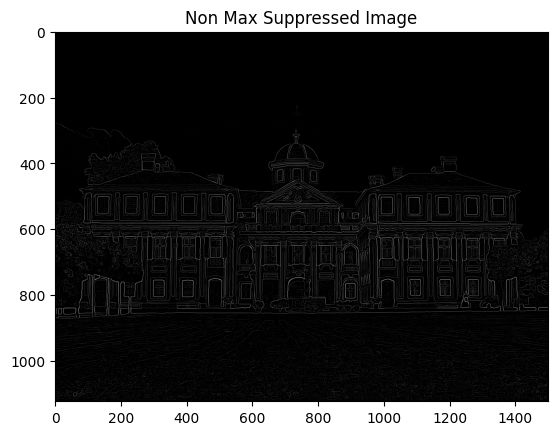

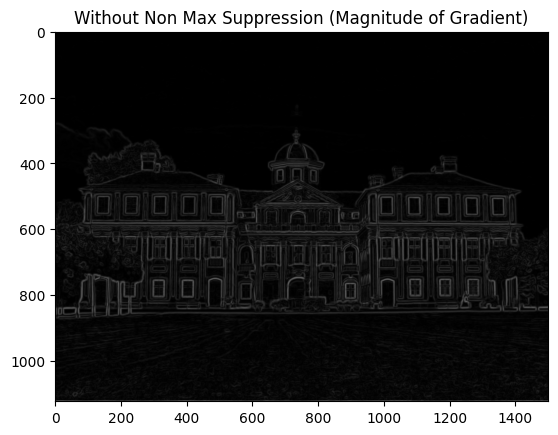

In [6]:
# algorithm for non max supression: go through all the pixels in the magnitude_gradient matrix and find the maximum intensity pixel in the direction of each edge.

def nonmax_suppression(magnitude_gradient,theta_array, angle_diff=15):
    rows,cols = magnitude_gradient.shape
    # instead of manually setting suppressed pixels to 0, i use a zero matrix of the same size as the gradient matrix
    suppressed = np.zeros((rows,cols))
    
    # convert matrix to degrees
    theta_array = theta_array * 180. / np.pi
    # convert negative angles to positive(theta_array has values between -180 and 180)
    theta_array = theta_array % 180

    grad_angles = [0,45,90,135]

    for row in range(1,rows-1):
        for col in range(1,cols-1):
            neighbour1 = 255
            neighbour2 = 255

            # gradient direction close 0 angle
            if (0 <= theta_array[row,col] < angle_diff or 180 - angle_diff <= theta_array[row,col] <= 180):
                neighbour1 = magnitude_gradient[row,col+1]
                neighbour2 = magnitude_gradient[row,col-1]

            # gradient direction close 45 angle
            elif (angle_diff <= theta_array[row,col] < 45 + angle_diff):
                neighbour1 = magnitude_gradient[row-1,col+1]
                neighbour2 = magnitude_gradient[row+1,col-1]

            # gradient direction close 90 angle
            elif (45 + angle_diff <= theta_array[row,col] < 90 + angle_diff):
                neighbour1 = magnitude_gradient[row-1,col]
                neighbour2 = magnitude_gradient[row+1,col]
            
            # gradient direction close 135 angle
            elif (90 + angle_diff <= theta_array[row,col] < 135 + angle_diff):
                neighbour1 = magnitude_gradient[row-1,col-1]
                neighbour2 =magnitude_gradient[row+1,col+1]
            
            # get the maximum pixel
            if magnitude_gradient[row,col] >= neighbour1 and magnitude_gradient[row,col] >= neighbour2:
                suppressed[row,col] = magnitude_gradient[row,col]
            else:
                # suppress the pixel at [row,col]
                pass
        
    return suppressed


nmx_suppressed_image = nonmax_suppression(magnitude_gradient,theta_array,22.5)

plt.imshow(nmx_suppressed_image,cmap='gray')
plt.title('Non Max Suppressed Image')
plt.show()

plt.imshow(magnitude_gradient,cmap='gray')
plt.title('Without Non Max Suppression (Magnitude of Gradient)')
plt.show()

#TODO: try with numpy vectorization

**c.** Use these edge pixels to mark out one of the floor on the building-- that is there should be an edge line in your image along one of the floors (most probably the window line) -- for this I want to see what are the assumptions you are making re the line you are detecting. Also stick to Least Square method of line fitting. Play with NMS (b above). Provide code, no opencv. (15 pts) 

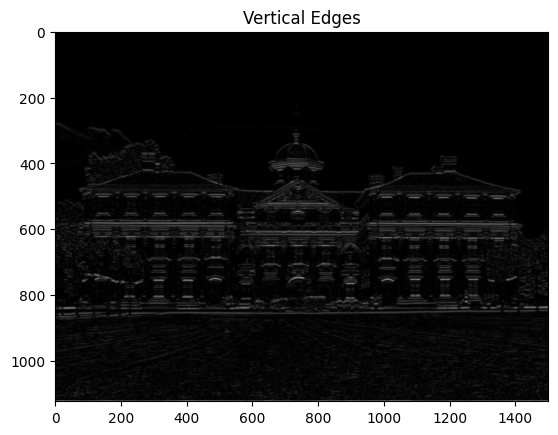

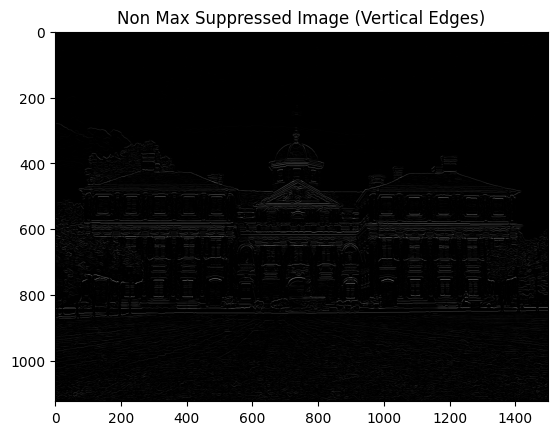

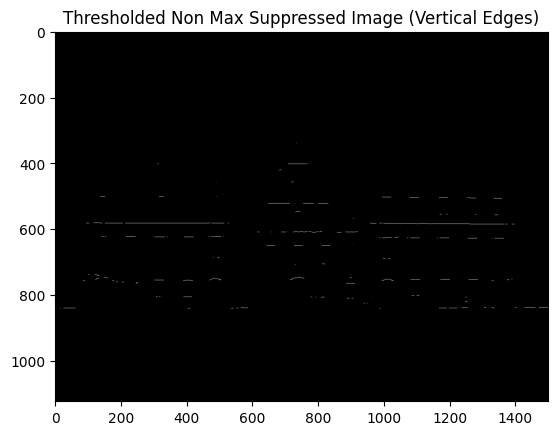

In [7]:
plt.imshow(np.abs(y_derivative),cmap='gray')
plt.title('Vertical Edges')
plt.show()

nmx_suppressed_image_y = nonmax_suppression(np.abs(y_derivative),theta_array,22.5)

plt.imshow(nmx_suppressed_image_y,cmap='gray')
plt.title('Non Max Suppressed Image (Vertical Edges)')
plt.show()

# threshold the gradient matrix
def threshold(gradient_image,min_threshold):
    rows,cols = gradient_image.shape
    thresholded = np.zeros((rows,cols))
    for row in range(rows):
        for col in range(cols):
            if gradient_image[row,col] > min_threshold:
                thresholded[row,col] = 255
    return thresholded

thresholded_y_derivative = threshold(nmx_suppressed_image_y,200)

plt.imshow(thresholded_y_derivative,cmap='gray')
plt.title('Thresholded Non Max Suppressed Image (Vertical Edges)')
plt.show()

Assumptions:

1. The gradient value near the window line should be higher than most other edges since a shadow is cast by right under it because of its protusion - can put a threshold on the gradient values to filter out most of the other vertical edges.

2. The gometry of the edge is linear horizontal, and the shadow along the window line seems uniform from the image, so we are expected to have a lot a of points in the same line along the window line.

3. The window line edge is vertical, so we should just use the vertical derivatives.

3. Geometry of the edges is linear, so we should use a hough transform for line detection only.

In [8]:
# implementing Hough Transform for line detection with fixed (m,c) space
def hough(gradient_matrix,m,c):
    rows,cols = gradient_matrix.shape
    accumulator =np.zeros((c,m))
    print('accumulator size:',accumulator.shape)
    for row in range(rows):
        for col in range(cols):
            if gradient_matrix[row,col] > 0:
                for i in range(m):
                    for j in range(c):
                        if row == i*col + j:
                            accumulator[j,i] += 1
    return accumulator

# creating the accumulator matrix using m and c parameters as the dimensions
m = 10
c = magnitude_gradient.shape[0]
accumulator = hough(thresholded_y_derivative,m,c)

# plt.imshow(accumulator,cmap='gray')
# plt.title('Hough Transform')
# plt.show()

# find the local maxima in the accumulator
def accumulator_local_maximum(accumulator,threshold=100.0):
    rows,cols = accumulator.shape
    local_maxima = []
    for row in range(rows):
        for col in range(cols):
            if accumulator[row,col] > threshold:
                print(accumulator[row,col])
                local_maxima.append((row,col,accumulator[row,col]))
    return local_maxima

local_maxima = accumulator_local_maximum(accumulator,100)
print(local_maxima)


accumulator size: (1124, 10)
105.0
389.0
121.0
152.0
121.0
104.0
[(523, 0, 105.0), (583, 0, 389.0), (584, 0, 121.0), (585, 0, 152.0), (586, 0, 121.0), (754, 0, 104.0)]


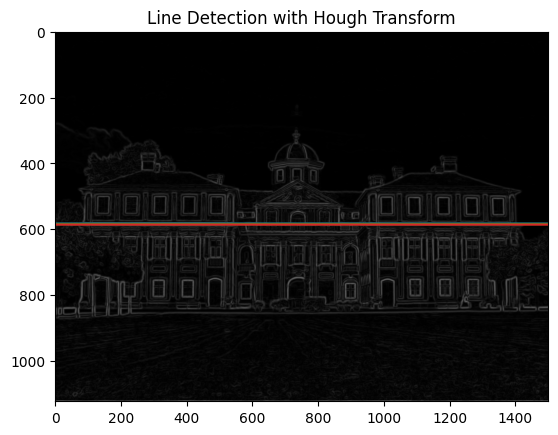

There are 4 lines right now close to the window line
Using a threshold on the y index to remove outliers, and taking least squares error to find the line of best fit for the window line


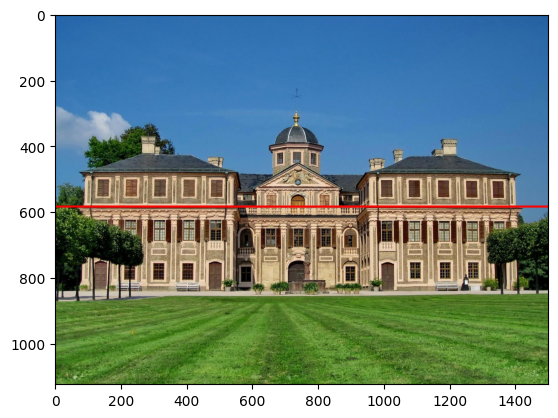

In [13]:
# filter out local maxima
local_maxima_sorted = sorted(local_maxima,key=lambda x:x[2],reverse=True)
max_threshold_index = local_maxima.index(max(local_maxima,key=lambda x:x[2]))
required_line = local_maxima[max_threshold_index]

# plot the lines on the magnitude_gradient plot
plt.imshow(magnitude_gradient,cmap='gray')
x = np.arange(0,magnitude_gradient.shape[1])
for c,m,_ in local_maxima_sorted[:4]:
    y = m*x + c
    plt.plot(x,y)
        
plt.title('Line Detection with Hough Transform')
plt.show()
# 3 of the lines of with maximum count in the hough transform are at the window line
print("There are 4 lines right now close to the window line")

print("Using a threshold on the y index to remove outliers, and taking least squares error to find the line of best fit for the window line")

# taking the line of best fit using least squares
squares_errors = []
outlier_threshold_y = 10
x = np.arange(0,magnitude_gradient.shape[1])
for c,m,_ in local_maxima_sorted[:4]:
    y = m*x + c
    cur_square_error = []
    for index,x_val in enumerate(x):
        y_val = y[index]
        y_true_vals = thresholded_y_derivative[y_val-outlier_threshold_y:y_val+outlier_threshold_y,x_val]
        y_true_vals[y_true_vals == 0] = y[index]
        # remove 0 values
        cur_square_error.append(np.square(y_true_vals - y[index]))
    squares_errors.append(np.sum(cur_square_error))

min_square_index = squares_errors.index(min(squares_errors))
bestfit_window_line = local_maxima_sorted[min_square_index]

plt.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))
c,m,_ = bestfit_window_line
x = np.arange(0,magnitude_gradient.shape[1])
y = m*x + c
plt.plot(x,y,color='red')
plt.show()

# TODO: what else playing around to be used with non max suppression